In [ ]:
# TODO Existem varios filtros MP/CA era giro percebermos quais são

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('budget-data/budget-data-extracted.csv')
df.shape

(6776, 13)

In [2]:
df.isna().sum()

company_name            0
quote_id                0
description             0
qty                    92
unit_price            315
filter_efficiency     228
dimensions             83
item_type             993
Length                245
Height                245
Gutter                245
Depth                5007
Pockets              5007
dtype: int64

In [3]:
cols_to_clean = ['unit_price', 'filter_efficiency','Length','Height','Gutter']
df_clean = df.dropna(subset=cols_to_clean)
df_clean.drop(['qty', 'Depth','Pockets','description','item_type'], axis=1, inplace=True)
df_clean.head()

C:\Users\João\AppData\Local\Temp\ipykernel_1140\2741972995.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(['qty', 'Depth','Pockets','description','item_type'], axis=1, inplace=True)


,company_name,quote_id,unit_price,filter_efficiency,dimensions,Length,Height,Gutter
0,A Preditiva,17171.0,7.5,G4,625.500.50,625.0,500.0,50.0
1,A Preditiva,17171.0,27.5,F7,625.500.50,625.0,500.0,50.0
2,A Preditiva,17175.0,28.5,F7,592.490.48,592.0,490.0,48.0
3,A Preditiva,18643.0,27.5,F7,592.592.45,592.0,592.0,45.0
4,A Preditiva,18643.0,17.5,F7,287.592.45,287.0,592.0,45.0


In [4]:
#Find individual names
names = df_clean['company_name'].unique()
proccessed_names = set()
for name in names:
    proccessed_names.add(re.sub(r'[^a-zA-Z]', '', str(name).lower()))

map_names = {}
for i, name in enumerate(proccessed_names):
    map_names[name] = i

In [5]:
df_model = df_clean.copy()
df_model['company_name'] = df_model['company_name'].apply(lambda x: map_names.get(re.sub(r'[^a-zA-Z]', '', str(x).lower())))

filterTypes = ["G1","G2","G3","G4","M5","M6","F7","F8","F9","H13","H14"]

def getFilterType(x):
    for filterType in filterTypes:
        if filterType in x:
            return filterType
    return np.nan

df_model['filter_efficiency'] = df_model['filter_efficiency'].apply(lambda x: getFilterType(x))
df_model = df_model.dropna(subset=['filter_efficiency'])

category_dummies = pd.get_dummies(df_model['filter_efficiency'], prefix='')
df_model.drop(['filter_efficiency','dimensions'], axis=1, inplace=True)

df_model = pd.concat([df_model, category_dummies], axis=1)
df_model.head()
df_model.to_csv('budget-data/budget-data-model.csv', index=False)
df_model.head()

,company_name,quote_id,unit_price,Length,Height,Gutter,_F7,_F8,_F9,_G2,_G3,_G4,_H13,_H14,_M5,_M6
0,181,17171.0,7.5,625.0,500.0,50.0,0,0,0,0,0,1,0,0,0,0
1,181,17171.0,27.5,625.0,500.0,50.0,1,0,0,0,0,0,0,0,0,0
2,181,17175.0,28.5,592.0,490.0,48.0,1,0,0,0,0,0,0,0,0,0
3,181,18643.0,27.5,592.0,592.0,45.0,1,0,0,0,0,0,0,0,0,0
4,181,18643.0,17.5,287.0,592.0,45.0,1,0,0,0,0,0,0,0,0,0


# K Neighbors Regressor

### For the General Model

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

#df_model2 = df_model.drop(['company_name'], axis=1)
df_model2 = df_model.drop(['company_name', 'quote_id'], axis=1)
#df_model2 = df_model.copy()
x_train, x_test, y_train, y_test = train_test_split(df_model2.drop(['unit_price'], axis=1), df_model2['unit_price'], test_size=0.2, random_state=42)
df_model2.head()

,unit_price,Length,Height,Gutter,_F7,_F8,_F9,_G2,_G3,_G4,_H13,_H14,_M5,_M6
0,7.5,625.0,500.0,50.0,0,0,0,0,0,1,0,0,0,0
1,27.5,625.0,500.0,50.0,1,0,0,0,0,0,0,0,0,0
2,28.5,592.0,490.0,48.0,1,0,0,0,0,0,0,0,0,0
3,27.5,592.0,592.0,45.0,1,0,0,0,0,0,0,0,0,0
4,17.5,287.0,592.0,45.0,1,0,0,0,0,0,0,0,0,0


### For the top 3 filters

In [7]:
df_G4 = df_model2[df_model2['_G4'] == 1]
df_F7 = df_model2[df_model2['_F7'] == 1]
df_M5 = df_model2[df_model2['_M5'] == 1]

In [171]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import math
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

def get_metrics(df, model, scoring_metric):

    x_train, x_test, y_train, y_test = train_test_split(df.drop(['unit_price'], axis=1), df['unit_price'], test_size=0.2, random_state=42)
    grid = GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 5, 7, 10, 15, 17, 20],
                         'weights': ('uniform', 'distance'),
                         'p': [1, 2, 3]},
            cv=5,
            scoring=scoring_metric)

    grid.fit(x_train, y_train)

    y_pred = grid.predict(x_test)

    return {
        'scoring_metric': scoring_metric,
        'model': model,
        'r2': r2_score(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': math.sqrt(mean_absolute_error(y_test, y_pred))
    }


metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error", "neg_root_mean_squared_error"]

columns = ['scoring_metric','model','r2', 'mse', 'mae', 'rmse']
df_new = pd.DataFrame(columns=columns)
for metric in metrics:
    for model in [(df_model2, "geral"), (df_G4, "G4"), (df_F7, "F7"), (df_M5, "M5")]:
        df_new = df_new.append(get_metrics(model[0], model[1], metric), ignore_index=True)
df_new.to_csv('results/KNNeighbors.csv', index=False)

In [175]:
temp = pd.read_csv('results/KNNeighbors.csv')
temp.sort_values(by=['model'], inplace=True)
temp.head(temp.shape[0])

,scoring_metric,model,r2,mse,mae,rmse
2,r2,F7,0.789150,44.327176,3.394644,1.842456
6,neg_mean_squared_error,F7,0.789150,44.327176,3.394644,1.842456
10,neg_mean_absolute_error,F7,0.826502,36.474577,3.299196,1.816369
14,neg_root_mean_squared_error,F7,0.817854,38.292704,3.425816,1.850896
1,r2,G4,0.407117,10.591515,1.426357,1.194302
5,neg_mean_squared_error,G4,0.408916,10.559390,1.421186,1.192135
9,neg_mean_absolute_error,G4,0.399881,10.720785,1.408649,1.186865
13,neg_root_mean_squared_error,G4,0.407117,10.591515,1.426357,1.194302
3,r2,M5,0.634940,12.387928,2.133321,1.460589
7,neg_mean_squared_error,M5,0.634940,12.387928,2.133321,1.460589


# Decision Tree

In [172]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import math
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

def get_metrics(df1, model, scoring_metric):

    x_train, x_test, y_train, y_test = train_test_split(df1.drop(['unit_price'], axis=1), df1['unit_price'], test_size=0.2, random_state=42)
    grid = GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ('squared_error', 'friedman_mse', 'absolute_error', 'poisson'),
                         'splitter': ('best', 'random'),
                         'max_features': ('auto', 'sqrt', 'log2')},
            cv=5,
            scoring=scoring_metric)

    grid.fit(x_train, y_train)

    y_pred = grid.predict(x_test)

    return {
        'scoring_metric': scoring_metric,	
        'model': model,
        'r2': r2_score(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': math.sqrt(mean_absolute_error(y_test, y_pred))
    }

metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error", "neg_root_mean_squared_error"]

columns = ['scoring_metric','model','r2', 'mse', 'mae', 'rmse']
df_new = pd.DataFrame(columns=columns)
for metric in metrics:
    for model in [(df_model2, "geral"), (df_G4, "G4"), (df_F7, "F7"), (df_M5, "M5")]:
        metrics = get_metrics(model[0], model[1], metric)
        df_new = df_new.append(metrics, ignore_index=True)

df_new.to_csv('results/decisionTree.csv', index=False)

In [176]:
temp = pd.read_csv('results/decisionTree.csv')
temp.sort_values(by=['model'], inplace=True)
temp.head(temp.shape[0])

,scoring_metric,model,r2,mse,mae,rmse
2,r2,F7,0.857354,29.988692,2.913593,1.706925
6,neg_mean_squared_error,F7,0.871418,27.031998,2.748234,1.657780
10,neg_mean_absolute_error,F7,0.884559,24.269241,2.696380,1.642066
14,neg_root_mean_squared_error,F7,0.870109,27.307162,2.742893,1.656168
1,r2,G4,0.221735,13.903268,1.562628,1.250051
5,neg_mean_squared_error,G4,0.224091,13.861172,1.546541,1.243600
9,neg_mean_absolute_error,G4,0.130948,15.525125,1.589768,1.260860
13,neg_root_mean_squared_error,G4,-0.150292,20.549318,1.581771,1.257685
3,r2,M5,0.515678,16.434966,2.429058,1.558543
7,neg_mean_squared_error,M5,0.449847,18.668846,2.470235,1.571698


# Random Forest

In [3]:
import numpy as np
from cuml import RandomForestClassifier as RandomForestClassifierGPU
import cupy as cp
from sklearn.ensemble import RandomForestClassifier
import time 

Hey


In [180]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import math
import warnings


def get_metrics(df1, model, scoring_metric):

    x_train, x_test, y_train, y_test = train_test_split(df1.drop(['unit_price'], axis=1), df1['unit_price'], test_size=0.2, random_state=42)
    grid = GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [10, 50, 100],
                         'criterion': ('squared_error', 'absolute_error'),
                         'min_samples_split': [1,2, 3],
                         'max_features': ( 'sqrt', 'log2')},
            cv=5,
            scoring=scoring_metric)

    grid.fit(x_train, y_train)

    y_pred = grid.predict(x_test)

    return {
        'scoring_metric': scoring_metric,	
        'model': model,
        'r2': r2_score(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': math.sqrt(mean_absolute_error(y_test, y_pred))
    }

metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error", "neg_root_mean_squared_error"]

columns = ['scoring_metric','model','r2', 'mse', 'mae', 'rmse']
df_new = pd.DataFrame(columns=columns)
for metric in metrics:
    for model in [(df_model2, "geral"), (df_G4, "G4"), (df_F7, "F7"), (df_M5, "M5")]:
        metrics = get_metrics(model[0], model[1], metric)
        print(metrics)
        df_new = df_new.append(metrics, ignore_index=True)

df_new.to_csv('results/RandomForest.csv', index=False)

KeyboardInterrupt: 

In [ ]:
temp = pd.read_csv('results/RandomForest.csv')
temp.sort_values(by=['model'], inplace=True)
temp.head(temp.shape[0])

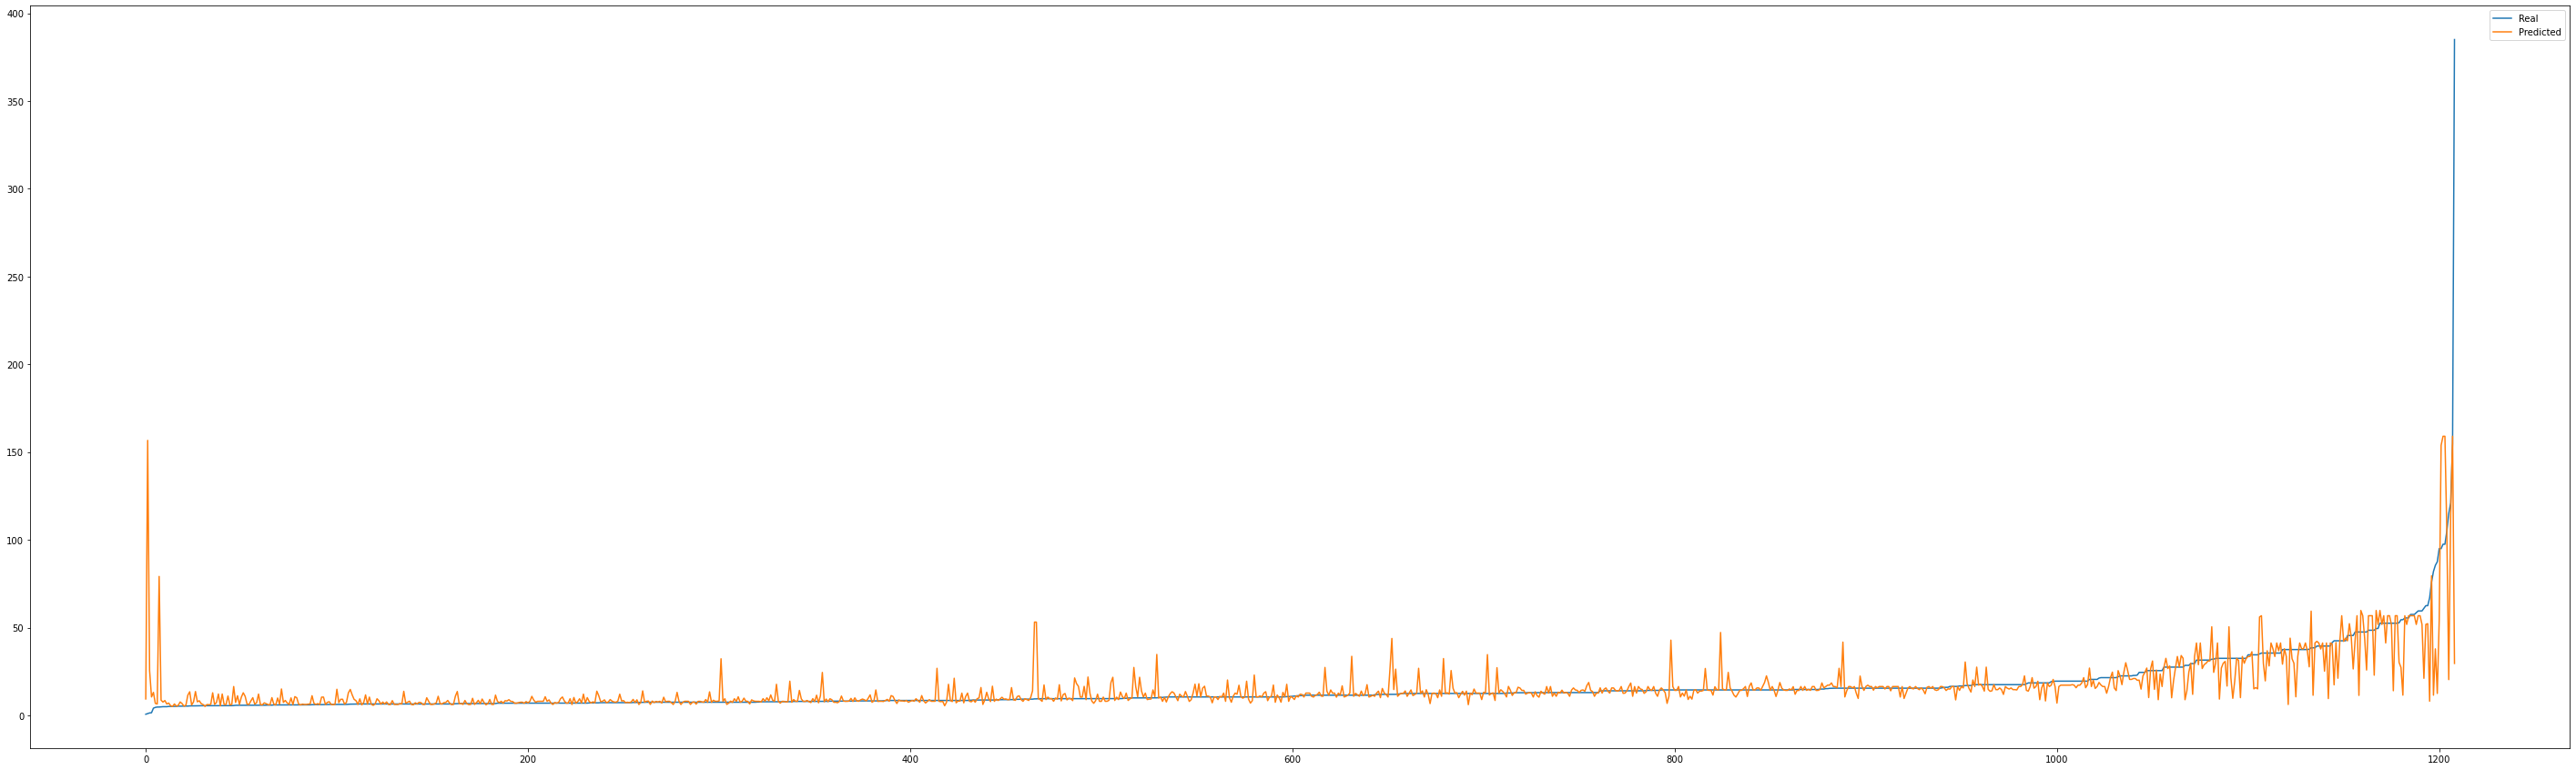

In [140]:
def plot_difference(y_test, y_pred):
    sorted_indices = np.argsort(y_test)

    # Apply sorting to both arrays using the sorted indices
    sorted_y_test = y_test.values[sorted_indices]
    sorted_y_pred = y_pred[sorted_indices]

    plt.figure(figsize=(50,15))
    plt.plot(sorted_y_test, label='Real')
    plt.plot(sorted_y_pred, label='Predicted')
    plt.legend()
    plt.show()

plot_difference(y_test, y_pred)

# 